In [1]:
import lightgbm as lgb
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split

In [2]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

In [3]:
# load the whole size dataset
X = np.load("London/X_all.npy")
Y_NO2 = np.load("London/Y_NO2_all.npy")
Y_PM10 = np.load("London/Y_PM10_all.npy")
Y_PM25 = np.load("London/Y_PM25_all.npy")

In [4]:
# calculate the symmetric mean absolute percentage error (SMAPE)
def get_score(pred, valid_y_exp):
    return np.mean(np.abs(pred - valid_y_exp) / (pred + valid_y_exp) * 2)

In [5]:
# lightgbm model parameters
# model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}

# model_param = {'lr': 0.1, 'depth': 10, 'tree': 300, 'leaf': 600, 'sample': 0.8, 'seed': 3}

# train and test the input X Y with the lightgbm model
def train_test(model_param, train_X, test_X, train_Y, test_Y, save_dir):
    time_start = time.time()
    lgb_train = lgb.Dataset(train_X, train_Y)
    lgb_eval = lgb.Dataset(test_X, test_Y, reference=lgb_train)
    
    params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'l2', 'l1'},
    'max_depth': model_param['depth'],
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'feature_fraction': 1,
    'bagging_fraction': model_param['sample'],
    'bagging_freq': 1,
    'bagging_seed': model_param['seed'],
#     'min_sum_hessian_in_leaf': 100,
    'verbose': 0
    }
    
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=model_param['tree'],
                    valid_sets=lgb_eval,
                    early_stopping_rounds=20)

    test_predict = gbm.predict(test_X)
    score = get_score(test_predict, test_Y)
    save_pkl(save_dir, gbm)
    print('running time: ', time.time() - time_start)
    return score

In [6]:
# PM 2.5

In [7]:
# split the Y_PM25, X into training part and testing part
train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25 = train_test_split(X, Y_PM25, test_size=0.2, random_state=11)
print(train_X_PM25.shape, test_X_PM25.shape, train_Y_PM25.shape, test_Y_PM25.shape)

(4325068, 198) (1081268, 198) (4325068,) (1081268,)


In [8]:
model_param = {'lr': 0.1, 'depth': 10, 'tree': 300, 'leaf': 600, 'sample': 0.8, 'seed': 3}
score = train_test(model_param, train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25, "London/lightgbm_PM25.model")
print('score: ', score)

[1]	valid_0's l1: 6.99304	valid_0's l2: 107.549
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 6.46596	valid_0's l2: 91.0032
[3]	valid_0's l1: 5.99903	valid_0's l2: 77.5335
[4]	valid_0's l1: 5.58678	valid_0's l2: 66.5183
[5]	valid_0's l1: 5.22222	valid_0's l2: 57.5122
[6]	valid_0's l1: 4.90222	valid_0's l2: 50.1355
[7]	valid_0's l1: 4.62101	valid_0's l2: 44.1223
[8]	valid_0's l1: 4.3749	valid_0's l2: 39.1681
[9]	valid_0's l1: 4.15837	valid_0's l2: 35.0983
[10]	valid_0's l1: 3.96996	valid_0's l2: 31.7516
[11]	valid_0's l1: 3.80509	valid_0's l2: 28.9666
[12]	valid_0's l1: 3.6568	valid_0's l2: 26.6229
[13]	valid_0's l1: 3.53234	valid_0's l2: 24.7354
[14]	valid_0's l1: 3.42285	valid_0's l2: 23.165
[15]	valid_0's l1: 3.32867	valid_0's l2: 21.863
[16]	valid_0's l1: 3.24069	valid_0's l2: 20.701
[17]	valid_0's l1: 3.16723	valid_0's l2: 19.7572
[18]	valid_0's l1: 3.10237	valid_0's l2: 18.9604
[19]	valid_0's l1: 3.04493	valid_0's l2: 18.267
[20]	valid_0's l1: 2.9

In [9]:
gbm = read_pkl("London/lightgbm_PM25.model")
test_X = np.load("London/X_test.npy")
test_Y = np.load("London/Y_PM25_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.3922580320439221

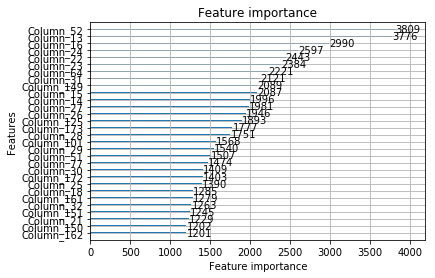

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()
'''
features = ['PM25_Concentration','PM10_Concentration','NO2_Concentration', # feature 0-2
            'temperature','pressure','humidity','wind_speed', 'wind_direction', # feature 3-7
            'holiday','time_month','time_week','time_day','time_hour','station_index', # feature 8-13
            
            'mean_PM25','mean_PM10','mean_NO2','mean_temperature','mean_pressure','mean_humidity','mean_wind_speed','mean_wind_direction', # feature 14-21
            'max_PM25','max_PM10','max_NO2','max_temperature','max_pressure','max_humidity','max_wind_speed', # feature 22-28
            'var_PM25','var_PM10','var_NO2','var_temperature','var_pressure','var_humidity','var_wind_speed','var_wind_speed', # feature 29-36
            'pressure_temperature','temperature_humidity','PM','PM25_10' # feature 37-40
            
            # feature 41-52: historical PM2.5 features
            # feature 53-64: historical PM10 features
            # feature 65-76: historical NO2 features
            # feature 77-100: historical temperature and forecasting features
            # feature 101-124: historical pressure and forecasting features
            # feature 125-148: historical humidity and forecasting features
            # feature 149-172: historical wind_speed and forecasting features
            # feature 173-196: historical wind_direction and forecasting features
            
            # feature 197: prediction id
            ]
'''

In [11]:
model_param = {'lr': 0.03, 'depth': 10, 'tree': 600, 'leaf': 600, 'sample': 0.8, 'seed': 3}
score = train_test(model_param, train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25, "London/lightgbm_PM25.model")
print('score: ', score)

[1]	valid_0's l1: 7.40923	valid_0's l2: 121.559
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 7.23558	valid_0's l2: 115.605
[3]	valid_0's l1: 7.06806	valid_0's l2: 109.996
[4]	valid_0's l1: 6.90629	valid_0's l2: 104.715
[5]	valid_0's l1: 6.74979	valid_0's l2: 99.7413
[6]	valid_0's l1: 6.59892	valid_0's l2: 95.0439
[7]	valid_0's l1: 6.45336	valid_0's l2: 90.6235
[8]	valid_0's l1: 6.3127	valid_0's l2: 86.4471
[9]	valid_0's l1: 6.17677	valid_0's l2: 82.5273
[10]	valid_0's l1: 6.04556	valid_0's l2: 78.8251
[11]	valid_0's l1: 5.9188	valid_0's l2: 75.3292
[12]	valid_0's l1: 5.79676	valid_0's l2: 72.0384
[13]	valid_0's l1: 5.67925	valid_0's l2: 68.9236
[14]	valid_0's l1: 5.56549	valid_0's l2: 65.98
[15]	valid_0's l1: 5.45603	valid_0's l2: 63.205
[16]	valid_0's l1: 5.35015	valid_0's l2: 60.5893
[17]	valid_0's l1: 5.24835	valid_0's l2: 58.1229
[18]	valid_0's l1: 5.15029	valid_0's l2: 55.8014
[19]	valid_0's l1: 5.05547	valid_0's l2: 53.6006
[20]	valid_0's l1: 4.

In [12]:
gbm = read_pkl("London/lightgbm_PM25.model")
# test_X = np.load("London/X_test.npy")
# test_Y = np.load("London/Y_PM25_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.36691321167736646

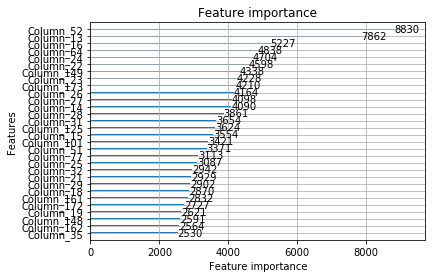

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

In [18]:
model_param = {'lr': 0.01, 'depth': 10, 'tree': 1000, 'leaf': 600, 'sample': 0.8, 'seed': 3}
score = train_test(model_param, train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25, "London/lightgbm_PM25_1.model")
print('score: ', score)

[1]	valid_0's l1: 7.52919	valid_0's l2: 125.754
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 7.46986	valid_0's l2: 123.668
[3]	valid_0's l1: 7.41103	valid_0's l2: 121.622
[4]	valid_0's l1: 7.353	valid_0's l2: 119.615
[5]	valid_0's l1: 7.29559	valid_0's l2: 117.649
[6]	valid_0's l1: 7.23885	valid_0's l2: 115.718
[7]	valid_0's l1: 7.18282	valid_0's l2: 113.827
[8]	valid_0's l1: 7.12736	valid_0's l2: 111.974
[9]	valid_0's l1: 7.07258	valid_0's l2: 110.155
[10]	valid_0's l1: 7.0184	valid_0's l2: 108.372
[11]	valid_0's l1: 6.96486	valid_0's l2: 106.624
[12]	valid_0's l1: 6.91192	valid_0's l2: 104.911
[13]	valid_0's l1: 6.8596	valid_0's l2: 103.226
[14]	valid_0's l1: 6.80789	valid_0's l2: 101.579
[15]	valid_0's l1: 6.75674	valid_0's l2: 99.9634
[16]	valid_0's l1: 6.7063	valid_0's l2: 98.3796
[17]	valid_0's l1: 6.65634	valid_0's l2: 96.8291
[18]	valid_0's l1: 6.607	valid_0's l2: 95.3053
[19]	valid_0's l1: 6.55829	valid_0's l2: 93.8123
[20]	valid_0's l1: 6.50

In [19]:
gbm = read_pkl("London/lightgbm_PM25_1.model")
# test_X = np.load("London/X_test.npy")
# test_Y = np.load("London/Y_PM25_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.34834325053068094

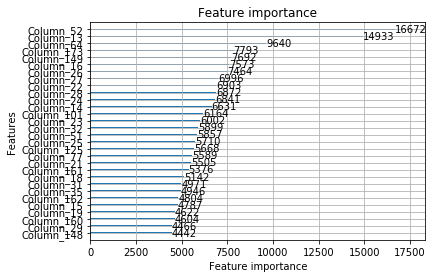

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

In [17]:
# model_param = {'lr': 0.01, 'depth': 10, 'tree': 4000, 'leaf': 600, 'sample': 0.8, 'seed': 3}
# score = train_test(model_param, train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25, "London/lightgbm_PM25_1.model")
# print('score: ', score)

In [ ]:
# gbm = read_pkl("London/lightgbm_PM25_1.model")
# # test_X = np.load("London/X_test.npy")
# # test_Y = np.load("London/Y_PM25_test.npy")
# test_predict = gbm.predict(test_X)
# score = get_score(test_predict, test_Y)
# score

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# ax = lgb.plot_importance(gbm, max_num_features=30)
# plt.show()

In [ ]:
# PM 10

In [16]:
# split the Y_PM10, X into training part and testing part

# train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10 = train_test_split(X, Y_PM10, test_size=0.2, random_state=11)
# print(train_X_PM10.shape, test_X_PM10.shape, train_Y_PM10.shape, test_Y_PM10.shape)

In [17]:
# train and test the lightgbm model with X and Y_PM10 data
# save the model parameters into lightgbm_PM10.model
# 48+ features and model_param = {'lr': 0.1, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}

# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [18]:
# train and test the lightgbm model with X and Y_PM10 data
# save the model parameters into lightgbm_PM10.model

# model_param = {'lr': 0.01, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [19]:
# model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [20]:
# model_param = {'lr': 0.01, 'depth': 10, 'tree': 10000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [12]:
# PM10_Concentration = train_X_PM10[:,1]
# s = get_score(PM10_Concentration.reshape((PM10_Concentration.shape[0], 1)), train_Y_PM10)
# print(s)

# PM10_Concentration = test_X_PM10[:,1]
# s = get_score(PM10_Concentration.reshape((PM10_Concentration.shape[0], 1)), test_Y_PM10)
# print(s)

In [ ]:
# NO2

In [21]:
# split the Y_NO2, X into training part and testing part

# train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_NO2, test_size=0.2, random_state=11)
# print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

In [6]:
# np.save("London/train_X_NO2_all.npy", train_X_NO2)

In [7]:
# np.save("London/test_X_NO2_all.npy", test_X_NO2)

In [8]:
# np.save("London/train_Y_NO2_all.npy", train_Y_NO2)

In [9]:
# np.save("London/test_Y_NO2_all.npy", test_Y_NO2)

In [22]:
# New model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# (5394355, 125)

# score = train_test(model_param, params, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "London/lightgbm_NO2.model")
# print('score: ', score)

In [4]:
# load the whole size dataset
train_X_NO2 = np.load("London/train_X_NO2_all.npy")
test_X_NO2 = np.load("London/test_X_NO2_all.npy")
train_Y_NO2 = np.load("London/train_Y_NO2_all.npy")
test_Y_NO2 = np.load("London/test_Y_NO2_all.npy")

In [23]:
# New model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# (5370393, 241)

# score = train_test(model_param, params, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "London/lightgbm_NO2.model")
# print('score: ', score)